## Let us import useful Packages

In [310]:
# Imports
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
%matplotlib inline

## Let us set Hyperparameters

In [311]:
## Hyperparameters
batch_size = 128
learning_rate = 0.001
input_size = 28*28
num_classes = 10

## Let us Download Datasets

In [312]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
# Training validation and test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
# testing dataset
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())
# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

## Let us Visualize Images

Label: 0


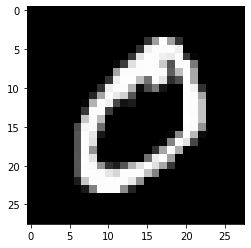

In [313]:
image, label = train_dataset[1]
plt.imshow(image, cmap='gray')
print('Label:', label)

## Let us set the Model

In [314]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

## Let us Check the Performance

In [315]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [316]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

## Let us evaluate the Model validation Dataset

In [317]:
evaluate(model, val_loader)

{'val_loss': 2.29082989692688, 'val_acc': 0.12080077826976776}

## Let us fix number epochs

In [318]:
# We trained for 5 epochs and 001
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9358, val_acc: 0.6105
Epoch [1], val_loss: 1.6721, val_acc: 0.7286
Epoch [2], val_loss: 1.4744, val_acc: 0.7678
Epoch [3], val_loss: 1.3250, val_acc: 0.7878
Epoch [4], val_loss: 1.2096, val_acc: 0.8011


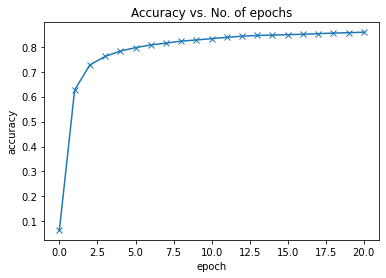

In [319]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Let us evaluate after epochs

In [320]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 1.2095826864242554, 'val_acc': 0.801074206829071}

## Let us evaluate with test Dataset

In [321]:
result = evaluate(model, test_loader)
result

{'val_loss': 1.1793087720870972, 'val_acc': 0.8125}

In [ ]:
## 

In [322]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


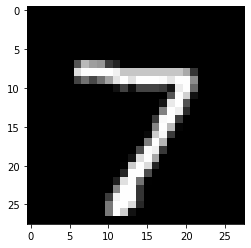

In [326]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Saving and loading the model

In [327]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [328]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0313,  0.0337,  0.0158,  ..., -0.0252,  0.0274, -0.0263],
                      [ 0.0219, -0.0088, -0.0258,  ...,  0.0044,  0.0049, -0.0027],
                      [-0.0351, -0.0211, -0.0097,  ...,  0.0250, -0.0284, -0.0043],
                      ...,
                      [-0.0321, -0.0236,  0.0080,  ..., -0.0026, -0.0311, -0.0217],
                      [-0.0080, -0.0312, -0.0272,  ..., -0.0042, -0.0132,  0.0199],
                      [-0.0109,  0.0173, -0.0069,  ..., -0.0058, -0.0070, -0.0229]])),
             ('linear.bias',
              tensor([-0.0427,  0.0730,  0.0117, -0.0257,  0.0104,  0.0379, -0.0437,  0.0068,
                      -0.0238,  0.0148]))])